# GOOGLECOLAB NOTEBOOK

In [0]:
import numpy as np 
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

from keras.applications import vgg16
from keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator
from keras.models import *
from keras.layers import *
from keras import optimizers
from keras.utils import np_utils

from PIL import Image
import requests
from io import BytesIO
import os
import pickle
import tqdm
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

Using TensorFlow backend.


In [0]:
### SET COLAB ENVIROMENT ###

# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
### READ DATA ###

df = pd.read_json('Crack.json', lines=True)
df['label'] = df.annotation.apply(lambda x: x['labels'][0] if len(x['labels'])==1 else 'Crack')
print(df.shape)
df.head()

(1428, 5)


,annotation,content,extras,metadata,label
0,"{'labels': ['no Crack'], 'note': ''}",http://com.dataturks.a96-i23.open.s3.amazonaws...,NaN,"{'first_done_at': 1528371420000, 'last_updated...",no Crack
1,"{'labels': ['Crack'], 'note': ''}",http://com.dataturks.a96-i23.open.s3.amazonaws...,NaN,"{'first_done_at': 1528373761000, 'last_updated...",Crack
2,"{'labels': ['Crack'], 'note': ''}",http://com.dataturks.a96-i23.open.s3.amazonaws...,NaN,"{'first_done_at': 1528371146000, 'last_updated...",Crack
3,"{'labels': ['Crack'], 'note': ''}",http://com.dataturks.a96-i23.open.s3.amazonaws...,NaN,"{'first_done_at': 1528371734000, 'last_updated...",Crack
4,"{'labels': ['no Crack'], 'note': ''}",http://com.dataturks.a96-i23.open.s3.amazonaws...,NaN,"{'first_done_at': 1528372265000, 'last_updated...",no Crack


In [0]:
### GET AND PREPARE IMAGES ###

images = []

for url in tqdm.tqdm(df['content']):
    
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize((224, 224))
    numpy_img = img_to_array(img)
    img_batch = np.expand_dims(numpy_img, axis=0)
    images.append(img_batch.astype('float16'))
    
images = np.vstack(images)
print(images.shape)

100%|██████████| 1428/1428 [13:05<00:00,  1.98it/s]


(1428, 224, 224, 3)


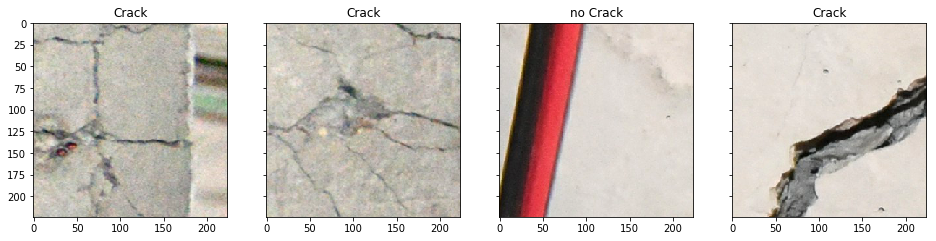

In [0]:
### RANDOM IMAGES PLOT ###

random_id = np.random.randint(0,images.shape[0],4)
f, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize = (16,10))

for ax, img, title in zip(axes.ravel(), images[random_id], df['label'][random_id]):
    ax.imshow(array_to_img(img))
    ax.set_title(title)

In [0]:
### IMPORT VGG16 ###

vgg_conv = vgg16.VGG16(weights='imagenet', include_top=False, input_shape = (224, 224, 3))

W0707 13:48:22.394008 140095917533056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0707 13:48:22.430056 140095917533056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0707 13:48:22.436434 140095917533056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0707 13:48:22.476953 140095917533056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



58892288/58889256 [==============================] - 1s 0us/step


W0707 13:48:23.941625 140095917533056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0707 13:48:23.942828 140095917533056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [0]:
# Freeze the layers except the last 2 convolutional blocks
for layer in vgg_conv.layers[:-8]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f6a7d8223c8> False
<keras.layers.convolutional.Conv2D object at 0x7f6a7d822c50> False
<keras.layers.convolutional.Conv2D object at 0x7f6a55424f28> False
<keras.layers.pooling.MaxPooling2D object at 0x7f6a4d280cc0> False
<keras.layers.convolutional.Conv2D object at 0x7f6a4d28c5f8> False
<keras.layers.convolutional.Conv2D object at 0x7f6a4d2338d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f6a4d2484e0> False
<keras.layers.convolutional.Conv2D object at 0x7f6a4d239a90> False
<keras.layers.convolutional.Conv2D object at 0x7f6a4d1e84e0> False
<keras.layers.convolutional.Conv2D object at 0x7f6a4d1f44e0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f6a4d20b908> False
<keras.layers.convolutional.Conv2D object at 0x7f6a4d19b390> True
<keras.layers.convolutional.Conv2D object at 0x7f6a4d1b96a0> True
<keras.layers.convolutional.Conv2D object at 0x7f6a4d1cdcc0> True
<keras.layers.pooling.MaxPooling2D object at 0x7f6a4d15f940> Tr

In [0]:
### ENCODE LABEL ###

Y = np_utils.to_categorical((df.label.values == 'Crack')+0)

In [0]:
### CREATE TRAIN TEST ###

X_train, X_test, y_train, y_test = train_test_split(images, Y, random_state = 42, test_size=0.2)

In [0]:
### MODIFY VGG STRUCTURE ###

x = vgg_conv.output
x = GlobalAveragePooling2D()(x)
x = Dense(2, activation="softmax")(x)

model = Model(vgg_conv.input, x)
model.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

model.summary()

W0707 13:48:38.870038 140095917533056 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
### INITIALIZE TRAIN GENERATOR ##

train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)

In [0]:
train_datagen.fit(X_train)

In [0]:
model.fit_generator(train_datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) / 32, epochs=20)

W0707 13:48:50.625329 140095917533056 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
36/35 [==============================] - 20s 565ms/step - loss: 0.6777 - acc: 0.5741
Epoch 2/20
36/35 [==============================] - 11s 298ms/step - loss: 0.6053 - acc: 0.7273
Epoch 3/20
36/35 [==============================] - 13s 355ms/step - loss: 0.5198 - acc: 0.7831
Epoch 4/20
36/35 [==============================] - 13s 352ms/step - loss: 0.4932 - acc: 0.7781
Epoch 5/20
36/35 [==============================] - 13s 352ms/step - loss: 0.4593 - acc: 0.7875
Epoch 6/20
36/35 [==============================] - 13s 352ms/step - loss: 0.3931 - acc: 0.8370
Epoch 7/20
36/35 [==============================] - 13s 350ms/step - loss: 0.3459 - acc: 0.8577
Epoch 8/20
36/35 [==============================] - 13s 350ms/step - loss: 0.3571 - acc: 0.8470
Epoch 9/20
36/35 [==============================] - 13s 352ms/step - loss: 0.3115 - acc: 0.8772
Epoch 10/20
36/35 [==============================] - 13s 350ms/step - loss: 0.3184 - acc: 0.8689
Epoch 11/20
36/35 [====================

In [0]:
print(classification_report(np.argmax(y_test,axis=1), np.argmax(model.predict(X_test/255),axis=1)))

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       162
           1       0.99      0.78      0.87       124

    accuracy                           0.90       286
   macro avg       0.92      0.89      0.90       286
weighted avg       0.91      0.90      0.90       286



In [0]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

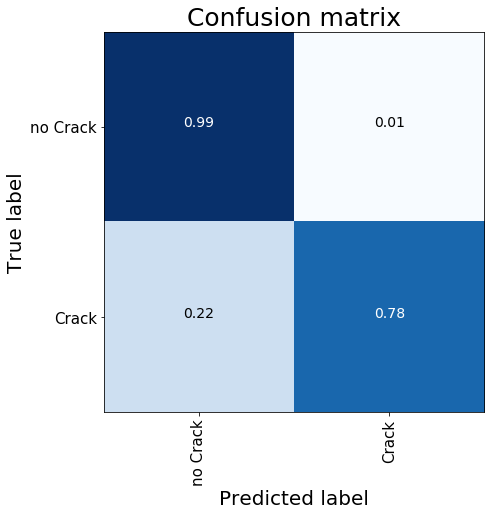

In [0]:
cnf_matrix = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(model.predict(X_test/255),axis=1))
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=df.label.unique(), title="Confusion matrix")
plt.show()

In [0]:
### CREATE FUNCTION TO DRAW ANOMALIES ###

def plot_activation(img):
  
    pred = model.predict(img[np.newaxis,:,:,:])
    pred_class = np.argmax(pred)
  
    weights = model.layers[-1].get_weights()[0]
    class_weights = weights[:, pred_class]
  
    intermediate = Model(model.input, model.get_layer("block5_conv3").output)
    conv_output = intermediate.predict(img[np.newaxis,:,:,:])
    conv_output = np.squeeze(conv_output)
  
    h = int(img.shape[0]/conv_output.shape[0])
    w = int(img.shape[1]/conv_output.shape[1])
  
    activation_maps = sp.ndimage.zoom(conv_output, (h, w, 1), order=1)
    out = np.dot(activation_maps.reshape((img.shape[0]*img.shape[1], 512)), class_weights).reshape(img.shape[0],img.shape[1])
  
    plt.imshow(img.astype('float32').reshape(img.shape[0],img.shape[1],3))
    plt.imshow(out, cmap='jet', alpha=0.35)
    plt.title('Crack' if pred_class == 1 else 'No Crack')

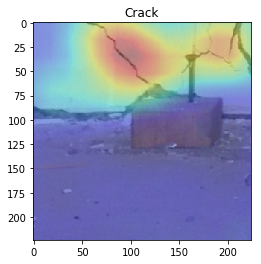

In [0]:
plot_activation(X_test[200]/255)

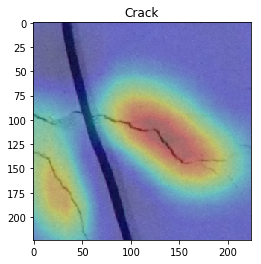

In [0]:
plot_activation(X_test[100]/255)

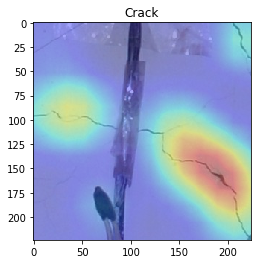

In [0]:
plot_activation(X_test[134]/255)